# Анализ лояльности пользователей Яндекс Афиши

## Этапы выполнения проекта

### 1. Загрузка данных и их предобработка

---

**Задача 1.1:** Напишите SQL-запрос, выгружающий в датафрейм pandas необходимые данные. Используйте следующие параметры для подключения к базе данных `data-analyst-afisha`:

- **Хост** — `rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net`
- **База данных** — `data-analyst-afisha`
- **Порт** — `6432`
- **Аутентификация** — `Database Native`
- **Пользователь** — `praktikum_student`
- **Пароль** — `Sdf4$2;d-d30pp`

Для выгрузки используйте запрос из предыдущего урока и библиотеку SQLAlchemy.

Выгрузка из базы данных SQL должна позволить собрать следующие данные:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---


In [1]:
!pip install sqlalchemy
!pip install psycopg2-binary

In [1]:
!pip install python-dotenv


In [2]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine

load_dotenv()

DB_USER = os.getenv('DB_USER', 'praktikum_student')
DB_PASSWORD = os.getenv('DB_PASSWORD', 'Sdf4$2;d-d30pp')
DB_HOST = os.getenv('DB_HOST', 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net')
DB_PORT = os.getenv('DB_PORT', '6432')
DB_NAME = os.getenv('DB_NAME', 'data-analyst-afisha')

connection_string = f"postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
engine = create_engine(connection_string)


In [6]:
query = '''
WITH set_config_precode AS (
    SELECT set_config('synchronize_seqscans', 'off', true)
)

SELECT user_id, device_type_canonical, order_id, 
created_dt_msk as order_dt, created_ts_msk as order_ts,
currency_code, revenue, tickets_count, events.event_id,
    (created_dt_msk::date 
     - LAG(created_dt_msk::date) OVER (
         PARTITION BY user_id
         ORDER BY created_dt_msk::date
       )
    ) AS days_since_prev,
event_name_code as event_name, 
event_type_main,
service_name, 
region_name, 
city_name
FROM afisha.purchases
JOIN afisha.events on afisha.events.event_id = afisha.purchases.event_id
JOIN afisha.city on afisha.city.city_id = afisha.events.city_id
JOIN afisha.regions on afisha.regions.region_id = afisha.city.region_id
WHERE device_type_canonical IN ('mobile', 'desktop') AND event_type_main != 'фильм'
ORDER BY user_id;

'''

In [7]:
df = pd.read_sql_query(query, con=engine)

In [8]:
df.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,event_id,days_since_prev,event_name,event_type_main,service_name,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,169230,NaN,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,237325,NaN,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,578454,75.0,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,387271,NaN,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,509453,83.0,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк


---

**Задача 1.2:** Изучите общую информацию о выгруженных данных. Оцените корректность выгрузки и объём полученных данных.

Предположите, какие шаги необходимо сделать на стадии предобработки данных — например, скорректировать типы данных.

Зафиксируйте основную информацию о данных в кратком промежуточном выводе.

---

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   event_id               290611 non-null  int64         
 9   days_since_prev        268678 non-null  float64       
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

In [10]:
print(df['device_type_canonical'].unique())
print(df['currency_code'].unique())

['mobile' 'desktop']
['rub' 'kzt']


290 611 заказов, то есть 290 611 строк. Выгрузка произведена корректно: все нужны фильтры и дополнительные столбцы остались.В датафрйеме отсутствуют пропущенные значения, кроме столбца days_since_prev, где это заложено и показывает, что юзер совершил лишь 1 покупку за все время. Типы данных верны.


---

###  2. Предобработка данных

Выполните все стандартные действия по предобработке данных:

---

**Задача 2.1:** Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведите выручку к единой валюте — российскому рублю.

Для этого используйте датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. Его можно загрузить по пути `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')`

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраните в новый столбец `revenue_rub`.

---


In [11]:
tenge_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

In [12]:
tenge_df.head()

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


In [13]:
tenge_df = tenge_df.rename(columns={'data': 'order_dt'})
tenge_df['order_dt'] = pd.to_datetime(tenge_df['order_dt'])
df['order_dt'] = pd.to_datetime(df['order_dt'])

In [14]:
df = df.merge(tenge_df[['order_dt', 'curs']], on='order_dt', how='left')

In [15]:
df['revenue_rub'] = df['revenue']

In [16]:
print(df.columns)


Index(['user_id', 'device_type_canonical', 'order_id', 'order_dt', 'order_ts',
       'currency_code', 'revenue', 'tickets_count', 'event_id',
       'days_since_prev', 'event_name', 'event_type_main', 'service_name',
       'region_name', 'city_name', 'curs', 'revenue_rub'],
      dtype='object')


In [17]:
mask_kzt = df['currency_code'] == 'kzt'

In [18]:
df.loc[mask_kzt, 'revenue_rub'] = (
    df.loc[mask_kzt, 'revenue'] *
    df.loc[mask_kzt, 'curs'] / 100
)


In [19]:
df[df['currency_code'] == 'kzt'][['order_dt', 'currency_code', 'revenue', 'revenue_rub']].head(3)

,order_dt,currency_code,revenue,revenue_rub
70,2024-09-17,kzt,518.10,98.503762
89,2024-09-02,kzt,347.18,65.731589
96,2024-09-09,kzt,328.77,61.148261


In [20]:
df[['order_dt', 'currency_code', 'revenue', 'revenue_rub']].head(3 
                                                                )

,order_dt,currency_code,revenue,revenue_rub
0,2024-08-20,rub,1521.94,1521.94
1,2024-07-23,rub,289.45,289.45
2,2024-10-06,rub,1258.57,1258.57


In [21]:
print(df.columns)


Index(['user_id', 'device_type_canonical', 'order_id', 'order_dt', 'order_ts',
       'currency_code', 'revenue', 'tickets_count', 'event_id',
       'days_since_prev', 'event_name', 'event_type_main', 'service_name',
       'region_name', 'city_name', 'curs', 'revenue_rub'],
      dtype='object')


---

**Задача 2.2:**

- Проверьте данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце `days_since_prev`.
- Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.
- Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.
    - Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.
    - Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.
        
        Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверьте данные в этих столбцах.
        
        Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.

После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

---

In [22]:
df['tickets_count'] = df['tickets_count'].astype('int16')

Выгрузка успешна, пропуски только в days_since_prev. Типы данных верны, но в столбце с количеством билетов в заказе можно сократить 

In [23]:
for col in ['device_type_canonical', 'event_type_main', 'service_name', 'region_name', 'city_name']:
    print(col, df[col].nunique(), df[col].unique())


device_type_canonical 2 ['mobile' 'desktop']
event_type_main 7 ['театр' 'выставки' 'другое' 'стендап' 'концерты' 'спорт' 'ёлки']
service_name 36 ['Край билетов' 'Мой билет' 'За билетом!' 'Лови билет!'
 'Билеты без проблем' 'Облачко' 'Лучшие билеты' 'Прачечная' 'Быстробилет'
 'Дом культуры' 'Весь в билетах' 'Билеты в руки' 'Тебе билет!'
 'Show_ticket' 'Городской дом культуры' 'Яблоко' 'Билет по телефону'
 'Выступления.ру' 'Росбилет' 'Шоу начинается!' 'Мир касс' 'Восьмёрка'
 'Телебилет' 'Crazy ticket!' 'Реестр' 'Быстрый кассир' 'КарандашРУ'
 'Радио ticket' 'Дырокол' 'Вперёд!' 'Кино билет' 'Цвет и билет' 'Зе Бест!'
 'Тех билет' 'Лимоны' 'Билеты в интернете']
region_name 81 ['Каменевский регион' 'Североярская область' 'Озернинский край'
 'Лугоградская область' 'Поленовский край' 'Широковская область'
 'Медовская область' 'Златопольский округ' 'Малиновоярский округ'
 'Яблоневская область' 'Ветренский регион' 'Боровлянский край'
 'Крутоводская область' 'Ягодиновская область' 'Серебряноярский

Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? 

Ответ: нет. 

Нормализацию проводить не требуется

device_type_canonical — 2 категории: mobile, desktop

event_type_main — 7 категорий: театр, выставки, другое, стендап, концерты, спорт, ёлки

В остальных столбцах категорий много в соответствии с географическим положением или названием

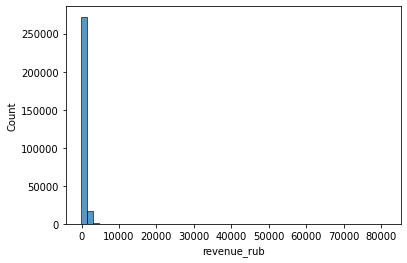

In [24]:
sns.histplot(df['revenue_rub'], bins=50)
plt.show()

Большинство заказов небольшие

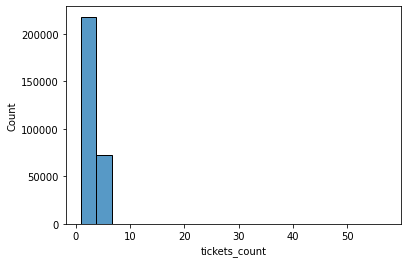

In [25]:
sns.histplot(df['tickets_count'], bins=20)
plt.show()

Количество билетов в заказе в основном 1–4 (>200.000 таких заказов), реже встречаются числом 4-7 (>60.000 )

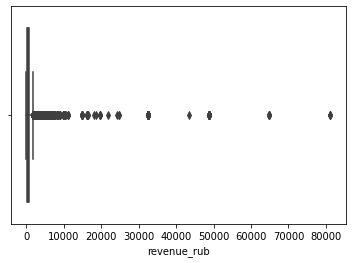

In [26]:
sns.boxplot(x=df['revenue_rub'])
plt.show()

Дополнительные сведения о выручке: Большинство заказов действительно небольшие, но встречаются и выброс до 80 тысяч рублей.ы

In [27]:
perc_99 = df['revenue_rub'].quantile(0.99)
print(perc_99)

2628.4217390400004


2628.42 — это показывает, что 99% заказов ≤ 2628 руб по выручке

In [28]:
total_rows = df.shape[0]
print(total_rows)

290611


In [29]:
outliers_count = (df['revenue_rub'] > perc_99).sum()
print(f"Выбросов выше 99 перцентиля: {outliers_count}")

Выбросов выше 99 перцентиля: 2825


---

### 3. Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** Постройте профиль пользователя — для каждого пользователя найдите:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавьте два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

**Рекомендация:** перед тем как строить профиль, отсортируйте данные по времени совершения заказа.

---


In [30]:
df = df.sort_values(by='order_dt') 

In [31]:
user_profile = df.groupby('user_id').agg(
    first_order_dt=('order_dt', 'min'),
    last_order_dt=('order_dt', 'max'),
    first_device=('device_type_canonical', 'first'),
    first_region=('region_name', 'first'),
    first_partner=('service_name', 'first'),
    first_genre=('event_type_main', 'first'),
    total_orders=('order_id', 'count'),
    avg_revenue_rub=('revenue_rub', 'mean'),
    avg_tickets=('tickets_count', 'mean'),
    avg_days_between_orders=('days_since_prev', 'mean')
).reset_index()

In [32]:
user_profile.head()

,user_id,first_order_dt,last_order_dt,first_device,first_region,first_partner,first_genre,total_orders,avg_revenue_rub,avg_tickets,avg_days_between_orders
0,0002849b70a3ce2,2024-08-20,2024-08-20,mobile,Каменевский регион,Край билетов,театр,1,1521.940000,4.000000,NaN
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,Каменевский регион,Мой билет,выставки,2,774.010000,3.000000,75.0
2,000898990054619,2024-07-13,2024-10-23,mobile,Североярская область,Лови билет!,другое,3,767.213333,2.666667,51.0
3,00096d1f542ab2b,2024-08-15,2024-08-15,desktop,Каменевский регион,Край билетов,театр,1,917.830000,4.000000,NaN
4,000a55a418c128c,2024-09-29,2024-10-15,mobile,Поленовский край,Лучшие билеты,театр,2,61.310000,1.500000,16.0


In [33]:
user_profile['is_two'] = (user_profile['total_orders'] >= 2).astype(int)
user_profile['is_five'] = (user_profile['total_orders'] >= 5).astype(int)

In [34]:
user_profile.head()

,user_id,first_order_dt,last_order_dt,first_device,first_region,first_partner,first_genre,total_orders,avg_revenue_rub,avg_tickets,avg_days_between_orders,is_two,is_five
0,0002849b70a3ce2,2024-08-20,2024-08-20,mobile,Каменевский регион,Край билетов,театр,1,1521.940000,4.000000,NaN,0,0
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,Каменевский регион,Мой билет,выставки,2,774.010000,3.000000,75.0,1,0
2,000898990054619,2024-07-13,2024-10-23,mobile,Североярская область,Лови билет!,другое,3,767.213333,2.666667,51.0,1,0
3,00096d1f542ab2b,2024-08-15,2024-08-15,desktop,Каменевский регион,Край билетов,театр,1,917.830000,4.000000,NaN,0,0
4,000a55a418c128c,2024-09-29,2024-10-15,mobile,Поленовский край,Лучшие билеты,театр,2,61.310000,1.500000,16.0,1,0


подготовили профиль пользователя, который поможет в дальнейшем исследовании и работе отделу маркетинга. Самое важное - профильм показывает активность каждого пользователя.

---

**Задача 3.2.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитайте:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучите статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оцените данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

In [35]:
total_users = user_profile.shape[0]
print(total_users)

21933


In [36]:
avg_orderrevenue = user_profile['avg_revenue_rub'].mean()
print(avg_orderrevenue)

574.020928951904


In [37]:
share_two_plus = (user_profile['is_two'] == 1).mean()
print(share_two_plus)

0.6182008845119227


In [38]:
share_five_plus = (user_profile['is_five'] == 1).mean()
print(share_five_plus)

0.29179774768613503


- общее число пользваотелей из профиля - 21933 
- средняя выручка с 1 заказа 574 рубля (усредненно по сренему по пользвоателям) 
- доля пользователей, совершивших 2 и более заказа - 0.618 (62%)
- доля пользователей, совершивших 5 и более заказов - 0.291 (30%)

In [39]:
stats = user_profile[['total_orders', 'avg_tickets', 'avg_days_between_orders']].describe()
print(stats)


       total_orders   avg_tickets  avg_days_between_orders
count  21933.000000  21933.000000             13559.000000
mean      13.249943      2.755987                15.808537
std      122.470535      0.920739                22.249582
min        1.000000      1.000000                 0.000000
25%        1.000000      2.000000                 1.000000
50%        2.000000      2.764151                 8.000000
75%        5.000000      3.125000                20.400000
max    10251.000000     12.000000               148.000000


По результатам оцените данные: 
достаточно ли их по объёму? - данных по объему достаточно 

есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов? - аномальные значения есть: в общем кол-ве заказов 75% - 5 заказов, а максимальный - 10 тысяч заказов! в среднем числе билетов аномалий нет, как и в среднем числе дней перерыва между покупками.

Разберемся с аномальным значением:

In [40]:
perc_99_orders = user_profile['total_orders'].quantile(0.99)
print(perc_99_orders) # видим, что 1% - больше 152 заказов, но никак не 10.251 - это явная аномалия, которая 
# искажает весь анализ

152.0


In [41]:
filtered_one = user_profile[user_profile['total_orders'] < user_profile['total_orders'].max()]

print(filtered_one.shape[0])

21932


In [42]:
print(filtered_one['total_orders'].max())

4368


In [43]:
filtered_profile = user_profile[user_profile['total_orders'] <= perc_99_orders]

print("Стало пользователей:", filtered_profile.shape[0])
print("Удалено:", user_profile.shape[0] - filtered_profile.shape[0])


Стало пользователей: 21714
Удалено: 219


In [44]:
filtered_profile[['total_orders', 'avg_tickets', 'avg_days_between_orders']].describe()


,total_orders,avg_tickets,avg_days_between_orders
count,21714.000000,21714.000000,13340.000000
mean,6.521691,2.756145,16.060418
std,14.335979,0.925214,22.343722
min,1.000000,1.000000,0.000000
25%,1.000000,2.000000,1.333333
50%,2.000000,2.769231,8.386752
75%,5.000000,3.142857,20.750000
max,152.000000,12.000000,148.000000


In [45]:
user_profile = filtered_profile


по итогу я избавилась от значений выше 99 процентиля, максимальное значение купленных билетов теперь составляет 152.

---

### 4. Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.



#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучите распределение пользователей по признакам.

- Сгруппируйте пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---


In [46]:
print(user_profile.head(3))

           user_id first_order_dt last_order_dt first_device  \
0  0002849b70a3ce2     2024-08-20    2024-08-20       mobile   
1  0005ca5e93f2cf4     2024-07-23    2024-10-06       mobile   
2  000898990054619     2024-07-13    2024-10-23       mobile   

           first_region first_partner first_genre  total_orders  \
0    Каменевский регион  Край билетов       театр             1   
1    Каменевский регион     Мой билет    выставки             2   
2  Североярская область   Лови билет!      другое             3   

   avg_revenue_rub  avg_tickets  avg_days_between_orders  is_two  is_five  
0      1521.940000     4.000000                      NaN       0        0  
1       774.010000     3.000000                     75.0       1        0  
2       767.213333     2.666667                     51.0       1        0  


In [47]:
genre_dist = (user_profile.groupby('first_genre').agg(users_count=('user_id', 'count'))
    .reset_index()
)

genre_dist['share'] = genre_dist['users_count'] / genre_dist['users_count'].sum()
genre_dist.sort_values('users_count', ascending=False)

,first_genre,users_count,share
2,концерты,9623,0.443170
1,другое,5415,0.249378
5,театр,4267,0.196509
4,стендап,1109,0.051073
3,спорт,799,0.036797
0,выставки,404,0.018606
6,ёлки,97,0.004467


In [48]:
device_dist = (user_profile.groupby('first_device').agg(users_count=('user_id', 'count'))
    .reset_index()
)

device_dist['share'] = device_dist['users_count'] / device_dist['users_count'].sum()
device_dist.sort_values('users_count', ascending=False)

,first_device,users_count,share
1,mobile,17964,0.8273
0,desktop,3750,0.1727


In [49]:
region_dist = (user_profile.groupby('first_region')
    .agg(users_count=('user_id', 'count'))
    .reset_index())
region_dist['share'] = region_dist['users_count'] / region_dist['users_count'].sum()
region_dist.sort_values('users_count', ascending=False).head(10)

,first_region,users_count,share
23,Каменевский регион,7127,0.328221
60,Североярская область,3769,0.173575
77,Широковская область,1234,0.056830
45,Озернинский край,673,0.030994
41,Малиновоярский округ,534,0.024592
76,Шанырский регион,503,0.023165
74,Травяная область,490,0.022566
57,Светополянский округ,460,0.021184
52,Речиновская область,434,0.019987
78,Яблоневская область,413,0.019020


In [50]:
partner_dist = (user_profile.groupby('first_partner')
    .agg(users_count=('user_id', 'count'))
    .reset_index()
)
partner_dist['share'] = partner_dist['users_count'] / partner_dist['users_count'].sum()

partner_dist.sort_values('users_count', ascending=False).head()


,first_partner,users_count,share
3,Билеты без проблем,5200,0.239477
22,Мой билет,2992,0.137791
19,Лови билет!,2798,0.128857
4,Билеты в руки,2556,0.117712
23,Облачко,2182,0.100488


Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. 
- У большинства людей первый тип мероприятия - концерт, последнее место - ёлки
- У большинства людей первый тип девайса - телефон, последнее место - компьютер
- У большинства людей первый регион - Каменевский регион, на 10 месте - Яблоневская область (НЕ последнее)
- У большинства людей первый партнер для покупки билетов - "Билеты без проблем", на 5 месте - "Облачко" (НЕ последнее)

Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

Неравномерно!
1) тип мероприятия:
Концерт занимает 44% как первое мероприятие, на которое был куплен билет, разница со вторым почти в 2 раза (24% - другое) 

2) девайс: 
Преобладает телефон, соотношение с компьютерной версией 82% на 17%

3) регион: 
32% из Канаевского района, разница со вторым местом почти в 2 раза (17% - Североярская область). Полседнее место - 
 Белоярская область с 1 юзером
 
4) партнер: 
24% ниши занимает партнер 	Билеты без проблем, разница со вторым местом почти в 2 раза (13% - Мой билет). Полседнее место - Crazy ticket! с 1 юзером, у которого этот партнер является первым при покупке. 

In [51]:
print(partner_dist.min()) 
print(region_dist.min()) 

first_partner    Crazy ticket!
users_count                  1
share                 0.000046
dtype: object
first_region    Белоярская область
users_count                      1
share                     0.000046
dtype: object


---

**Задача 4.1.2.** Проанализируйте возвраты пользователей:

- Для каждого сегмента вычислите долю пользователей, совершивших два и более заказа.
- Визуализируйте результат подходящим графиком. Если сегментов слишком много, то поместите на график только 10 сегментов с наибольшим количеством пользователей. Такое возможно с сегментами по региону и по билетному оператору.
- Ответьте на вопросы:
    - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
    - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

---


In [52]:
user_orders = df.groupby('user_id')['order_id'].nunique().reset_index()
user_orders.columns = ['user_id', 'orders_count']
user_orders['is_returned'] = user_orders['orders_count'] >= 2
print(user_orders)

               user_id  orders_count  is_returned
0      0002849b70a3ce2             1        False
1      0005ca5e93f2cf4             2         True
2      000898990054619             3         True
3      00096d1f542ab2b             1        False
4      000a55a418c128c             2         True
...                ...           ...          ...
21928  fff13b79bd47d7c             9         True
21929  fff32fc9ad0f9f6             2         True
21930  fffcd3dde79eb2c            33         True
21931  fffeeb3c120cf0b             1        False
21932  ffff00725179321             1        False

[21933 rows x 3 columns]


In [53]:
df.columns

Index(['user_id', 'device_type_canonical', 'order_id', 'order_dt', 'order_ts',
       'currency_code', 'revenue', 'tickets_count', 'event_id',
       'days_since_prev', 'event_name', 'event_type_main', 'service_name',
       'region_name', 'city_name', 'curs', 'revenue_rub'],
      dtype='object')

In [54]:
users_with_segment = df[['user_id', 'region_name']].drop_duplicates()

data = users_with_segment.merge(user_orders, on='user_id')


In [55]:
segment_stats = (
    data.groupby('region_name')
    .agg(
        users=('user_id', 'nunique'),
        returned_users=('is_returned', 'sum')
    )
)

segment_stats['return_rate'] = (
    segment_stats['returned_users'] / segment_stats['users']
)


In [56]:
overall_return_rate = user_orders['is_returned'].mean()
print(round(overall_return_rate, 3)) #находим среднюю долю возвратов по выборке

0.618


In [57]:
top_regions = (
    segment_stats
    .sort_values('users', ascending=False)
    .head(10)
)
print(top_regions)

                      users  returned_users  return_rate
region_name                                             
Каменевский регион    10632            7954     0.748119
Североярская область   6710            5353     0.797765
Широковская область    3269            2835     0.867238
Озернинский край       2480            2176     0.877419
Малиновоярский округ   1895            1662     0.877045
Светополянский округ   1678            1520     0.905840
Речиновская область    1532            1373     0.896214
Яблоневская область    1428            1260     0.882353
Медовская область      1394            1242     0.890961
Лугоградская область   1390            1233     0.887050


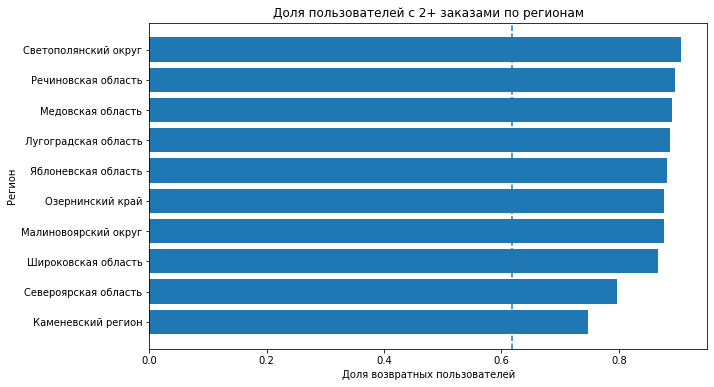

In [58]:
top_regions = top_regions.sort_values('return_rate')

plt.figure(figsize=(10,6))
plt.barh(top_regions.index, top_regions['return_rate'])
plt.axvline(overall_return_rate, linestyle='--')  # средняя линия
plt.title('Доля пользователей с 2+ заказами по регионам')
plt.xlabel('Доля возвратных пользователей')
plt.ylabel('Регион')
plt.show()


 Ответьте на вопросы:
 
 ---
 
Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
- Пользователи из Светополянского округа возвращаются в 90% процентах случаев, закрывает десятку по удержанию Каменевский регион (75%)

Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?
- Да, наблюдаются. Средняя доля пользователей с повторными заказами по выборке составляет 60%. В ряде регионов данный показатель превышает средний уровень. Также встречаются  

In [59]:
top_regions = (
    segment_stats
    .sort_values('return_rate', ascending=True)
    .head(10)
)
print(top_regions)

                        users  returned_users  return_rate
region_name                                               
Теплоозёрский округ         5               3     0.600000
Каменевский регион      10632            7954     0.748119
Речицкий регион           287             220     0.766551
Североключевской округ    104              80     0.769231
Верхоречная область       738             581     0.787263
Североярская область     6710            5353     0.797765
Островогорский округ       20              16     0.800000
Островная область          79              64     0.810127
Шанырский регион          866             706     0.815242
Крутоводский регион        11               9     0.818182


Тут возникла неурядица: получается, что при среднем значении 0.618 среднее занчение по региону минимальное составляет 0.6 (еще и мало пользователей в нем), а дальше уже с числом return_rate гораздо выше, что не сопоставляется с числом 0.618. как так? и сичтаеся ли тогда мой ответ верным?

---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

In [60]:
df_sorted = df.sort_values('order_dt')
first_orders = df_sorted.groupby('user_id').first().reset_index()
first_orders = first_orders[['user_id', 'event_type_main']]
print(first_orders)

               user_id event_type_main
0      0002849b70a3ce2           театр
1      0005ca5e93f2cf4        выставки
2      000898990054619          другое
3      00096d1f542ab2b           театр
4      000a55a418c128c           театр
...                ...             ...
21928  fff13b79bd47d7c          другое
21929  fff32fc9ad0f9f6         стендап
21930  fffcd3dde79eb2c        концерты
21931  fffeeb3c120cf0b         стендап
21932  ffff00725179321        концерты

[21933 rows x 2 columns]


In [61]:
first_orders = first_orders.merge(
    user_orders[['user_id', 'is_returned']],
    on='user_id'
)
print(first_orders)

               user_id event_type_main  is_returned
0      0002849b70a3ce2           театр        False
1      0005ca5e93f2cf4        выставки         True
2      000898990054619          другое         True
3      00096d1f542ab2b           театр        False
4      000a55a418c128c           театр         True
...                ...             ...          ...
21928  fff13b79bd47d7c          другое         True
21929  fff32fc9ad0f9f6         стендап         True
21930  fffcd3dde79eb2c        концерты         True
21931  fffeeb3c120cf0b         стендап        False
21932  ffff00725179321        концерты        False

[21933 rows x 3 columns]


In [62]:
hyp1_stats = (
    first_orders
    .groupby('event_type_main')
    .agg(
        users=('user_id', 'nunique'),
        return_rate=('is_returned', 'mean')
    )
)

print(hyp1_stats)

                 users  return_rate
event_type_main                    
выставки           412     0.638350
другое            5487     0.601057
концерты          9709     0.624266
спорт              808     0.564356
стендап           1111     0.607561
театр             4314     0.639082
ёлки                92     0.532609


In [63]:
hyp1_stats.loc[['спорт', 'концерты']]

,users,return_rate
event_type_main,,
спорт,808,0.564356
концерты,9709,0.624266


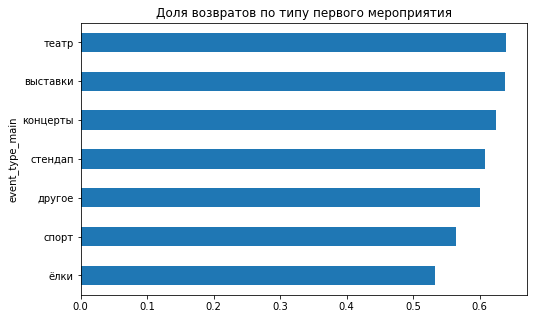

In [64]:
hyp1_stats.sort_values('return_rate')['return_rate'].plot(
    kind='barh',
    figsize=(8,5),
    title='Доля возвратов по типу первого мероприятия'
)
plt.show()

Гипотеза 1. Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.

Пользователи, которые совершили первый заказ на спортивные мероприятия, возвращаются реже (56%) по сравнению с теми, кто начал с концертов (62%). Гипотеза не подтверждена. Но тип мероприятия действительно влияет на вероятность возврата на Яндекс Афишу


In [65]:
users_with_region = df[['user_id', 'region_name']].drop_duplicates()
data_region = users_with_region.merge(user_orders[['user_id', 'is_returned']], on='user_id')



In [66]:
region_stats = (
    data_region.groupby('region_name')
    .agg(
        users=('user_id', 'nunique'),          # количество уникальных пользователей
        returned_users=('is_returned', 'sum')  # сколько вернулось
    )
)
region_stats['return_rate'] = region_stats['returned_users'] / region_stats['users']
region_stats = region_stats.sort_values('users', ascending=False)  # сортируем по активности
region_stats.head(10)

,users,returned_users,return_rate
region_name,,,
Каменевский регион,10632,7954,0.748119
Североярская область,6710,5353,0.797765
Широковская область,3269,2835,0.867238
Озернинский край,2480,2176,0.877419
Малиновоярский округ,1895,1662,0.877045
Светополянский округ,1678,1520,0.905840
Речиновская область,1532,1373,0.896214
Яблоневская область,1428,1260,0.882353
Медовская область,1394,1242,0.890961


In [67]:
top_regions = region_stats.head(10)
print(top_regions)

                      users  returned_users  return_rate
region_name                                             
Каменевский регион    10632            7954     0.748119
Североярская область   6710            5353     0.797765
Широковская область    3269            2835     0.867238
Озернинский край       2480            2176     0.877419
Малиновоярский округ   1895            1662     0.877045
Светополянский округ   1678            1520     0.905840
Речиновская область    1532            1373     0.896214
Яблоневская область    1428            1260     0.882353
Медовская область      1394            1242     0.890961
Лугоградская область   1390            1233     0.887050


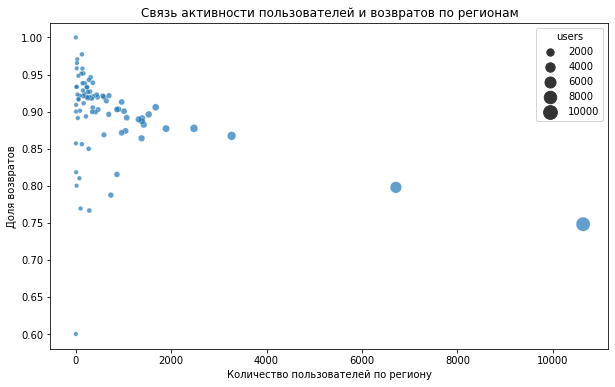

In [68]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=region_stats,
    x='users',
    y='return_rate',
    size='users',
    sizes=(20, 200),
    alpha=0.7
)
plt.xlabel('Количество пользователей по региону')
plt.ylabel('Доля возвратов')
plt.title('Связь активности пользователей и возвратов по регионам')
plt.show()


Гипотеза 2. В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

В двух самых обширных по количеству пользователей регионах доля возвратов в районе 75-80%, а в регионах меньше (от 0 до 1000) чаще встречаются возвраты 90-95%. Гипотеза не подтверждена

---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучите количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** Проследите связь между средней выручкой сервиса с заказа и повторными заказами.

- Постройте сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответьте на вопросы:
    - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
    - Есть ли различия между группами?

Текст на сером фоне:
    
**Рекомендация:**

1. Используйте одинаковые интервалы (`bins`) и прозрачность (`alpha`), чтобы визуально сопоставить распределения.
2. Задайте параметру `density` значение `True`, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

---


In [69]:
user_revenue = df.groupby('user_id').agg(
    total_revenue=('revenue_rub', 'sum'),
    total_tickets=('tickets_count', 'sum')
).reset_index()
print(user_revenue)

               user_id  total_revenue  total_tickets
0      0002849b70a3ce2        1521.94              4
1      0005ca5e93f2cf4        1548.02              6
2      000898990054619        2301.64              8
3      00096d1f542ab2b         917.83              4
4      000a55a418c128c         122.62              3
...                ...            ...            ...
21928  fff13b79bd47d7c        6192.39             23
21929  fff32fc9ad0f9f6        1701.99              5
21930  fffcd3dde79eb2c       18410.98             92
21931  fffeeb3c120cf0b         661.53              2
21932  ffff00725179321         802.25              2

[21933 rows x 3 columns]


In [70]:
user_revenue['avg_revenue_rub'] = user_revenue['total_revenue'] / user_revenue['total_tickets']

user_revenue = user_revenue.merge(user_orders[['user_id', 'is_returned']], on='user_id')
print(user_revenue)

               user_id  total_revenue  total_tickets  avg_revenue_rub  \
0      0002849b70a3ce2        1521.94              4       380.485000   
1      0005ca5e93f2cf4        1548.02              6       258.003333   
2      000898990054619        2301.64              8       287.705000   
3      00096d1f542ab2b         917.83              4       229.457500   
4      000a55a418c128c         122.62              3        40.873333   
...                ...            ...            ...              ...   
21928  fff13b79bd47d7c        6192.39             23       269.234348   
21929  fff32fc9ad0f9f6        1701.99              5       340.398000   
21930  fffcd3dde79eb2c       18410.98             92       200.119348   
21931  fffeeb3c120cf0b         661.53              2       330.765000   
21932  ffff00725179321         802.25              2       401.125000   

       is_returned  
0            False  
1             True  
2             True  
3            False  
4             True

In [71]:
one_order = user_revenue[user_revenue['is_returned'] == False]  # 1 заказ
returned = user_revenue[user_revenue['is_returned'] == True]   # 2+ заказа

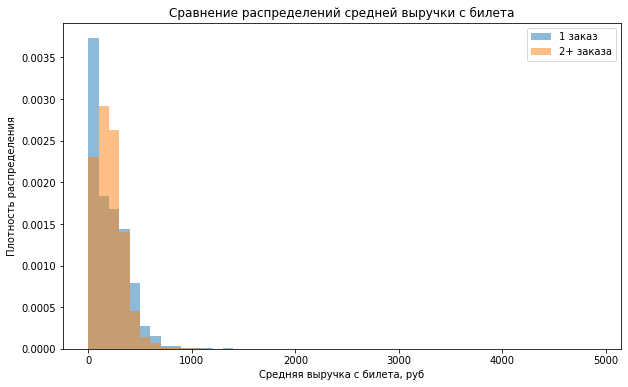

In [72]:
plt.figure(figsize=(10,6))

bins = range(0, 5000, 100)  

plt.hist(one_order['avg_revenue_rub'], bins=bins, alpha=0.5, density=True, label='1 заказ')
plt.hist(returned['avg_revenue_rub'], bins=bins, alpha=0.5, density=True, label='2+ заказа')

plt.xlabel('Средняя выручка с билета, руб')
plt.ylabel('Плотность распределения')
plt.title('Сравнение распределений средней выручки с билета')
plt.legend()
plt.show()


Ответьте на вопросы:

В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
- Самая часто встречающаяся выручка 200 рублей для пользователей,  совершивших более одного заказа и около 100 рублей для пользователей с одним заказом. 

Есть ли различия между группами?
- Да, различия в распредлении есть. например, для пользвоателей с одним заказом свойственна выручка до 100 рублей, а с выручкой выше плотность распределения сильно резко снижается. а вот для возвратных пользователей свойтсвенная выручка вплоть до 300 рублей за 1 билет, но с выурчкой выше плотность не так сильно снижается (плотность распределения выше, чем у невозвратных пользователей)

---

**Задача 4.2.2.** Сравните распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


In [73]:
user_revenue_full = user_revenue.merge(
    user_orders[['user_id', 'orders_count']],
    on='user_id'
)

In [74]:
group_2_4 = user_revenue_full[(user_revenue_full['orders_count'] >= 2) & 
                               (user_revenue_full['orders_count'] <= 4)]

group_5_plus = user_revenue_full[user_revenue_full['orders_count'] >= 5]

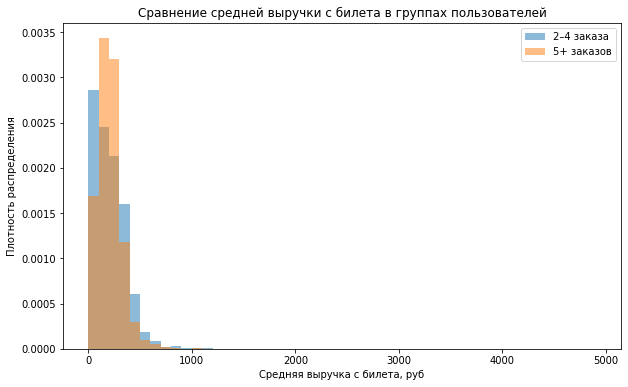

In [75]:
plt.figure(figsize=(10,6))

bins = range(0, 5000, 100)

plt.hist(group_2_4['avg_revenue_rub'], bins=bins, alpha=0.5, density=True, label='2–4 заказа')
plt.hist(group_5_plus['avg_revenue_rub'], bins=bins, alpha=0.5, density=True, label='5+ заказов')

plt.xlabel('Средняя выручка с билета, руб')
plt.ylabel('Плотность распределения')
plt.title('Сравнение средней выручки с билета в группах пользователей')
plt.legend()
plt.show()


Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?
- да, есть. и для более лояльных пользвателей (с бОльшим кол-вом заказов) средняя выручка выше, наиболее плотно она в районе 200-300 рублей с билета, тогда как для пользователей с 2-4 заказами наиболее плотно она в районе 100. 

---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучите распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и опишите основные наблюдения.
- Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответьте на вопросы:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

---

In [76]:
user_tickets = df.groupby('user_id')['tickets_count'].mean().reset_index()
user_tickets.columns = ['user_id', 'avg_tickets_count']


user_data = user_orders.merge(user_tickets, on='user_id')


In [77]:
bins = [0, 2, 3, 5, float('inf')]
labels = ['1-2 билета', '2-3 билета', '3-5 билетов', '5+ билетов']

user_data['tickets_segment'] = pd.cut(user_data['avg_tickets_count'], bins=bins, labels=labels, right=False)


In [78]:
segment_stats = user_data.groupby('tickets_segment').agg(
    users=('user_id', 'nunique'),
    returned_users=('is_returned', 'sum')
)

segment_stats['return_rate'] = segment_stats['returned_users'] / segment_stats['users']
segment_stats


,users,returned_users,return_rate
tickets_segment,,,
1-2 билета,2401,1229,0.511870
2-3 билета,9642,7145,0.741029
3-5 билетов,9201,5052,0.549071
5+ билетов,689,133,0.193033


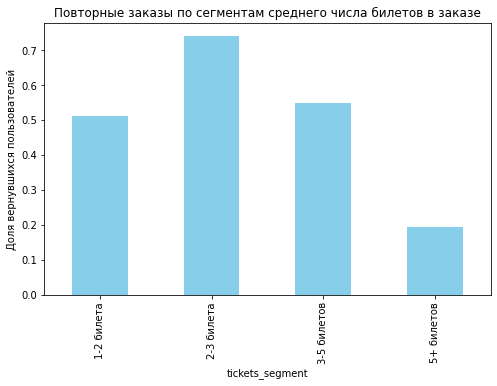

In [79]:
plt.figure(figsize=(8,5))
segment_stats['return_rate'].plot(kind='bar', color='skyblue')
plt.ylabel('Доля вернувшихся пользователей')
plt.title('Повторные заказы по сегментам среднего числа билетов в заказе')
plt.show()


по сегментам видно, что особенно много пользоваталей в сегментах 2-3 и 3-5 билетов - 9642 и 9201 соответственное, когда как 1-2 билета	2401, а 5+ совсем мало - 689 пользователей. Чаще всеовозвращаются пользователи , которые покупали 2-3 билета в своем заказе. 

Как распределены пользователи по сегментам — равномерно или сконцентрировано?
- скорее, сконцентрировано в двух серединных сегментах.
Есть ли сегменты с аномально высокой или низкой долей повторных покупок?
- больше всех выделяется второй сегмент(2-3) билета, а ниже всех 5+ билетов. это ожидаемо и не является аномалией, а отражает особенности поведения пользователей.

---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

---


In [80]:
df_sorted = df.sort_values('order_dt')
first_orders = df_sorted.groupby('user_id').first().reset_index()
first_orders = first_orders[['user_id', 'order_dt']]

In [81]:
first_orders = first_orders.merge(
    user_orders[['user_id', 'is_returned']],
    on='user_id'
)
print(first_orders)

               user_id   order_dt  is_returned
0      0002849b70a3ce2 2024-08-20        False
1      0005ca5e93f2cf4 2024-07-23         True
2      000898990054619 2024-07-13         True
3      00096d1f542ab2b 2024-08-15        False
4      000a55a418c128c 2024-09-29         True
...                ...        ...          ...
21928  fff13b79bd47d7c 2024-07-16         True
21929  fff32fc9ad0f9f6 2024-08-15         True
21930  fffcd3dde79eb2c 2024-06-20         True
21931  fffeeb3c120cf0b 2024-09-24        False
21932  ffff00725179321 2024-09-25        False

[21933 rows x 3 columns]


In [82]:
# 0=понедельник, 6=воскресенье 
first_orders['weekday'] = first_orders['order_dt'].dt.day_name()

# Группируем по дню недели
weekday_stats = (
    first_orders.groupby('weekday')
    .agg(users=('user_id', 'nunique'), returned_users=('is_returned', 'sum')
    )
)
weekday_stats['return_rate'] = weekday_stats['returned_users'] / weekday_stats['users']

print(weekday_stats.sort_values('return_rate', ascending=False))


           users  returned_users  return_rate
weekday                                      
Saturday    3461            2219     0.641144
Monday      2947            1868     0.633865
Wednesday   3084            1927     0.624838
Tuesday     3218            2010     0.624612
Sunday      2819            1708     0.605889
Friday      3274            1962     0.599267
Thursday    3130            1865     0.595847


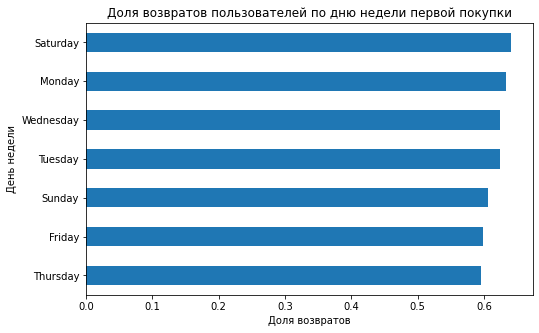

In [83]:
weekday_stats.sort_values('return_rate')['return_rate'].plot(
    kind='barh',
    figsize=(8,5),
    title='Доля возвратов пользователей по дню недели первой покупки'
)
plt.xlabel('Доля возвратов')
plt.ylabel('День недели')
plt.show()


- По данным даты первого заказа выделите день недели. Сделано 
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте. Сделано
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

Вероятность возврата в любом случае в районе 60-65%, но самая большая доля возвратов, если пользователь совершает свой первый заказ в субботу. 

---

**Задача 4.3.2.** Изучите, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитайте среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

---


In [85]:
user_orders_stats = ( df.sort_values('order_dt').groupby('user_id').agg(
          orders_count=('order_id', 'nunique'),
          first_order=('order_dt', 'min'),
          last_order=('order_dt', 'max')    ).reset_index())

In [86]:
user_orders_stats['lifetime_days'] = (user_orders_stats['last_order'] - user_orders_stats['first_order']).dt.days

user_orders_stats['avg_days_between_orders'] = None

print(user_orders_stats)

               user_id  orders_count first_order last_order  lifetime_days  \
0      0002849b70a3ce2             1  2024-08-20 2024-08-20              0   
1      0005ca5e93f2cf4             2  2024-07-23 2024-10-06             75   
2      000898990054619             3  2024-07-13 2024-10-23            102   
3      00096d1f542ab2b             1  2024-08-15 2024-08-15              0   
4      000a55a418c128c             2  2024-09-29 2024-10-15             16   
...                ...           ...         ...        ...            ...   
21928  fff13b79bd47d7c             9  2024-07-16 2024-10-31            107   
21929  fff32fc9ad0f9f6             2  2024-08-15 2024-10-28             74   
21930  fffcd3dde79eb2c            33  2024-06-20 2024-10-30            132   
21931  fffeeb3c120cf0b             1  2024-09-24 2024-09-24              0   
21932  ffff00725179321             1  2024-09-25 2024-09-25              0   

      avg_days_between_orders  
0                        None  

In [87]:
mask = user_orders_stats['orders_count'] > 1
user_orders_stats.loc[mask, 'avg_days_between_orders'] = (
    user_orders_stats.loc[mask, 'lifetime_days'] / (user_orders_stats.loc[mask, 'orders_count'] - 1)
)
user_orders_stats['is_returned'] = user_orders_stats['orders_count'] >= 2

In [88]:
print(user_orders_stats)

               user_id  orders_count first_order last_order  lifetime_days  \
0      0002849b70a3ce2             1  2024-08-20 2024-08-20              0   
1      0005ca5e93f2cf4             2  2024-07-23 2024-10-06             75   
2      000898990054619             3  2024-07-13 2024-10-23            102   
3      00096d1f542ab2b             1  2024-08-15 2024-08-15              0   
4      000a55a418c128c             2  2024-09-29 2024-10-15             16   
...                ...           ...         ...        ...            ...   
21928  fff13b79bd47d7c             9  2024-07-16 2024-10-31            107   
21929  fff32fc9ad0f9f6             2  2024-08-15 2024-10-28             74   
21930  fffcd3dde79eb2c            33  2024-06-20 2024-10-30            132   
21931  fffeeb3c120cf0b             1  2024-09-24 2024-09-24              0   
21932  ffff00725179321             1  2024-09-25 2024-09-25              0   

      avg_days_between_orders  is_returned  
0                 

In [89]:
# разделили юзеров на группы
group_2_4 = user_orders_stats[(user_orders_stats['orders_count'] >= 2) & (user_orders_stats['orders_count'] <= 4)]

# 5 и более заказов
group_5_plus = user_orders_stats[user_orders_stats['orders_count'] >= 5]

In [90]:
avg_interval_2_4 = group_2_4['avg_days_between_orders'].mean()
avg_interval_5_plus = group_5_plus['avg_days_between_orders'].mean()

In [91]:
print(f"Средний интервал между заказами для 2–4 заказов: {avg_interval_2_4:.2f} дней")
print(f"Средний интервал между заказами для 5+ заказов: {avg_interval_5_plus:.2f} дней")

Средний интервал между заказами для 2–4 заказов: 21.33 дней
Средний интервал между заказами для 5+ заказов: 9.64 дней


Рассчитайте среднее время между заказами для двух групп пользователей:

совершившие 2–4 заказа - 21.33 день 

совершившие 5 и более заказов. - 9.64 дней

---



Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы:

Чем лояльнее по кол-ву заказов пользователь, тем чаще он их совершает. 

---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 4.4.1:** Проведите корреляционный анализ:
- Рассчитайте коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). При необходимости используйте параметр `interval_cols` для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в `total_orders`. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю `total_orders`, а затем повторите корреляционный анализ. Выделите такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.
- Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?

---

In [92]:
!pip install phik 

In [93]:
import phik  

user_orders = df.groupby('user_id')['order_id'].nunique().reset_index()
user_orders.columns = ['user_id', 'total_orders']

In [94]:
user_profile = df[['user_id', 'device_type_canonical', 'region_name', 'city_name', 'service_name']].drop_duplicates()

user_data = user_profile.merge(user_orders, on='user_id')

In [99]:
interval_cols = ['total_orders']


phik_corr = user_data.drop(columns=['user_id']).phik_matrix(interval_cols=interval_cols)

In [100]:
print(phik_corr['total_orders'].sort_values(ascending=False))

total_orders             1.000000
city_name                0.271035
region_name              0.211597
service_name             0.109743
device_type_canonical    0.091959
Name: total_orders, dtype: float64


In [101]:
def segment_orders(x):
    if x == 1:
        return '1 заказ'
    elif 2 <= x <= 4:
        return '2-4 заказа'
    else:
        return '5+ заказов'

user_data['orders_segment'] = user_data['total_orders'].apply(segment_orders)


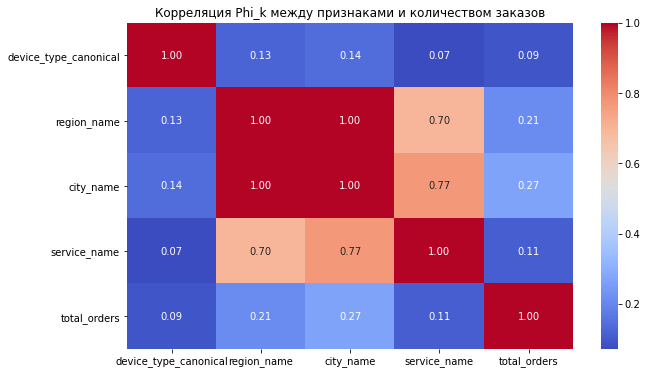

In [102]:
plt.figure(figsize=(10, 6))
sns.heatmap(phik_corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Корреляция Phi_k между признаками и количеством заказов')
plt.show()


In [103]:
user_orders['total_orders'].value_counts()

1       8374
2       3582
3       2176
4       1401
5        980
        ... 
1478       1
167        1
279        1
343        1
1647       1
Name: total_orders, Length: 333, dtype: int64

Проанализируйте полученные результаты.
• Phi_k > 0.3–0.4 — заметная связь (city_name)
• 0.1–0.3 — слабая или умеренная связь (region_name, service_name) 
• близко к 0 — связь практически отсутствует (device_type_canonical)

Если полученные значения будут близки к нулю, проверьте разброс данных в total_orders. 
Проверила: Большинство пользователей сделали 1 заказ, меньшая часть — 2–4, ещё меньше — 5+ заказов. 

Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?
Связанные с количеством заказов признаки по убыванию:
- город 0.27 умеренная связь (ниже - слабая) 
- регион 
- оператор 
- тип устройство

### 5. Общий вывод и рекомендации

В конце проекта напишите общий вывод и рекомендации: расскажите заказчику, на что нужно обратить внимание. В выводах кратко укажите:

- **Информацию о данных**, с которыми вы работали, и то, как они были подготовлены: например, расскажите о фильтрации данных, переводе тенге в рубли, фильтрации выбросов.
- **Основные результаты анализа.** Например, укажите:
    - Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?
    - Какие признаки первого заказа связаны с возвратом пользователей?
    - Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
    - Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?
    - Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?
- Дополните выводы информацией, которая покажется вам важной и интересной. Следите за общим объёмом выводов — они должны быть компактными и ёмкими.

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.

Информация о данных:

    Работали с выборкой из 29 0611 строк. Данные были подготовлены: удалены выбросы (число заказов >152), при необходимости переведена валюта казахстана в рубли, фильтровались некорректные значения. доабвлены дополнительные столбцы. 


Основные результаты анализа:
- Сколько пользователей в выборке? - 21 714
- Как распределены пользователи по числу заказов? Средний пользователь сделал 2 заказа; 62% пользователей совершили 2+ заказа, 30% — 5+ заказов.
- Какие ещё статистические показатели вы подсчитали важным во время изучения данных? медианная средняя выручка с одного заказа — 574 руб., среднее число билетов — 2–3, интервалы между покупками варьируются от 1 до 20 дней, были удалены аномалии по числу заказов (>152)
- Какие признаки первого заказа связаны с возвратом пользователей? Тип мероприятия (концерты — высокая вовлечённость), тип устройства (мобильные пользователи чаще возвращаются), регион и билетный оператор первого заказа
- Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок? Связь слабая
- Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)? Интервалы между покупками: чем короче промежуток, тем выше вероятность возврата. день недели влияет слабо, но заказы в выходные немного чаще приводят к повторным покупкам
- Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа? Число заказов коррелирует с городом, регионом, типом устройства, типом меропритяия и опертаором билетов


Рекомендации: 
- Активнее работать с крупными сегментами первого заказа: концерты, мобильные пользователи, регионы с большой долей возврата

- Разрабатывать программы удержания для пользователей с 1–2 заказами

- Использовать билетных партнёров с высокой конверсией

- Отслеживать интервалы между заказами

### 6. Финализация проекта и публикация в Git

Когда вы закончите анализировать данные, оформите проект, а затем опубликуйте его.

Выполните следующие действия:

1. Создайте файл `.gitignore`. Добавьте в него все временные и чувствительные файлы, которые не должны попасть в репозиторий.
2. Сформируйте файл `requirements.txt`. Зафиксируйте все библиотеки, которые вы использовали в проекте.
3. Вынести все чувствительные данные (параметры подключения к базе) в `.env`файл.
4. Проверьте, что проект запускается и воспроизводим.
5. Загрузите проект в публичный репозиторий — например, на GitHub. Убедитесь, что все нужные файлы находятся в репозитории, исключая те, что в `.gitignore`. Ссылка на репозиторий понадобится для отправки проекта на проверку. Вставьте её в шаблон проекта в тетрадке Jupyter Notebook перед отправкой проекта на ревью.

**Вставьте ссылку на проект в этой ячейке тетрадки перед отправкой проекта на ревью.**